# Feature Extraction
Starting with a raw text corpus, we need to extract the features that we will represent in our model. Features are numerical representations of the text. Features may correspond with words - these will act as column labels - we'll interpret 
## Bag-of-words

In this step, we convert the raw text into numerical features for analysis. We have to convert both the keywords and text data. Let's start with the keywords

In [1]:
import pandas as pd
import numpy as np

train = pd.read_csv('../downloads/train.csv')
test = pd.read_csv('../downloads/test.csv')

train.keyword.fillna('',inplace=True)
test.keyword.fillna('',inplace=True)
train.location.fillna('',inplace=True)
test.location.fillna('',inplace=True)

train.sample(5)

,id,keyword,location,text,target
4857,6916,mass%20murderer,,You happen to conveniently 'forget' about how ...,1
3819,5428,first%20responders,New York City,I just added 'Sandy First Responders Lost Thei...,1
3957,5625,flooding,Jakarta/Kuala Lumpur/S'pore,#Laos flooding -10 villages underwater World V...,1
6996,10032,twister,"Calgary, Alberta",Anyone wanna come over and watch Twister with ...,0
3862,5493,flames,"Hillsville/Lynchburg, VA",@Flames_Nation that's the optimistic side of m...,0


In [3]:
from nltk import TweetTokenizer
tt = TweetTokenizer(strip_handles=True, reduce_len=True)

from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(tokenizer=tt.tokenize)
cv.fit(train['text'])

# Vectorize keywords and tweets
# First the training set
train_keywords = pd.DataFrame(pd.get_dummies(train.keyword,prefix='KW'))
train_tweets = pd.DataFrame(cv.transform(train['text']).toarray(),columns=cv.get_feature_names())
X_train = pd.concat([train_keywords,train_tweets],axis=1)
y_train = train.target

test_keywords = pd.DataFrame(pd.get_dummies(test.keyword,prefix='KW'))
test_tweets = pd.DataFrame(cv.transform(test['text']).toarray(),columns=cv.get_feature_names())
X_test = pd.concat([test_keywords,test_tweets],axis=1)

# Models
## Ridge Classifier
Let's start out with a very simple model: a ridge classifier. How well do we do for classification?

In [4]:
from sklearn.linear_model import RidgeClassifier

model = RidgeClassifier()
model.fit(X_train,y_train)

RidgeClassifier()

In [5]:
y_pred = model.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

NameError: name 'y_test' is not defined

### Dropping the keyword data

Let's see if the results look quite as good if we drop the keyword data.

In [5]:
model2 = RidgeClassifier()
model2.fit(cv.transform(train['text']).toarray(),y_train)
y_pred = model2.predict(cv.transform(test['text']).toarray())
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4342
           1       1.00      0.99      0.99      3271

    accuracy                           0.99      7613
   macro avg       0.99      0.99      0.99      7613
weighted avg       0.99      0.99      0.99      7613



Dropping the keyword features has no appreciable impact on the model. The tweet text contains all the information necessary to decide the classification. 

## How does the model decide?
Ridge classification is based on a linear regression model with L2 regularization. Each feature has an associated coefficient that weights the prediction towards or away from the Disaster target class. We can see how the coefficients each contribute to the final decision. 

First, let's look at how the coefficients are distributed.

In [39]:
coef = [(X_train.columns[i],model.coef_[0,i]) for i in range(len(X_train.columns))]
coef = sorted(coef, key = lambda x: x[1], reverse=True)

print('Top 20 terms favoring Disaster:', ' '.join([x[0] for x in coef[:20]]))
print('Top 20 terms favoring Not Disaster:', ' '.join([x[0] for x in coef[-20:]]))

Top 20 terms favoring Disaster: http://t.co/tatzfk63ch http://t.co/jdtpirnm76 #nochilllukehammings http://t.co/ltmgdp6jaf https://t.co/ucsudk3q1d http://t.co/qkrltrd39b x1392 https://t.co/gf5qjgoyci http://t.co/ngkrzpza45 un-imaginable http://t.co/m19ivwrdkk https://t.co/4vwsl2gfp0 moly riots daviesmutia jrowah http://t.co/iap4lwvqsw balls http://t.co/ouylwuixcs externally
Top 20 terms favoring Not Disaster: http://t.co/m5djllxozp cake practice sold http://t.co/nzrwddlntp desire http://t.co/f7wqpcekg2 gmail slicker pharrell http://t.co/fucoqhclad poll http://t.co/hrqcjdovjz http://t.co/qzqc8wwwcn http://t.co/zdj2hyf6ro http://t.co/devybnvxgq http://t.co/5zdbtktww7 http://t.co/6gldwx71da http://t.co/qzlpfhpwdo http://t.co/zy3hpdjnwg


The terms that the regression most heavily weight are dominated by http addresses. This raises some questions:

* Are these addresses unique across the dataset?
* Do they correlate perfectly with the target?
* What would happen to the accuracy of a model if they're eliminated as features?
* Why do they have such high weights?
* How many tokens are unique among the test and training set?

Let's repeat the modeling by eliminating addresses:

In [41]:
import re
cv = CountVectorizer(tokenizer=tt.tokenize)
cv.fit(train['text'].apply(lambda x: re.sub('(http|@)[!-~]*(\s|$)', '',x)))

# Vectorize keywords and tweets
# First the training set
train_keywords = pd.DataFrame(pd.get_dummies(train.keyword,prefix='KW'))
train_tweets = pd.DataFrame(cv.transform(train['text']).toarray(),columns=cv.get_feature_names())
X_train = pd.concat([train_keywords,train_tweets],axis=1)
y_train = train.target

test_keywords = pd.DataFrame(pd.get_dummies(test.keyword,prefix='KW'))
test_tweets = pd.DataFrame(cv.transform(test['text']).toarray(),columns=cv.get_feature_names())
X_test = pd.concat([test_keywords,test_tweets],axis=1)
y_test = test.target

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [42]:
model = RidgeClassifier()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4342
           1       0.99      0.97      0.98      3271

    accuracy                           0.98      7613
   macro avg       0.98      0.98      0.98      7613
weighted avg       0.98      0.98      0.98      7613



In [45]:
coef = [(X_train.columns[i],model.coef_[0,i]) for i in range(len(X_train.columns))]
coef = sorted(coef, key = lambda x: x[1], reverse=True)

top_number = 100

print('Top', top_number, 'terms favoring Disaster:', ' '.join([x[0] for x in coef[:100]]),'\n')
print('Top ', top_number, ' terms favoring Not Disaster:', ' '.join([x[0] for x in coef[-100:]]))

Top 20 terms favoring Disaster: ks94 blink x1392 #nochilllukehammings riots distance sevenfigz un-imaginable ryans balls ij moly daviesmutia jrowah massacre externally narrowly pileq tianta thruuu nails faceåê hyider_ghost chim pornhub liberal suing mwednesday sign-up earthquake fandom hiroshima stab #elephantintheroom shore threatens grateful quarter #forbesasia bf snow helene #tnn mall cd horrible abs tornado o'clock apt #hiroshima cos #ferguson's onto aware gainesville riveeer sincere dothraki neon hailstorm arm fires alil #mudslide dan dumb woods that'd harms extraordinaire taxis wildfire countries peacetime fireball derailment thirsty suddenly begins lightening obligations defs KW_mass%20murder dreamy bucs 2.5 peacefully stealing pikin ipod panda sunset flood mo KW_suicide%20bombing 158-0853 hypo storms eyesss 

Top 20 terms favoring Not Disaster: skies KW_blight KW_smoke tickets bigamist donnie writing removal hero's #radiation angry bruh sale åêm concentration anti fixing placed

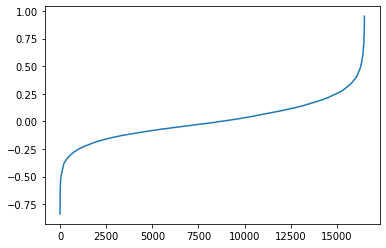

Number of features:  16500


In [47]:
plt.plot(sorted(model.coef_[0,:]))
plt.show()
print("Number of features: ", model.coef_.size)

In [48]:
for col in X_train.columns:
    print(col,end=' ')

KW_ KW_ablaze KW_accident KW_aftershock KW_airplane%20accident KW_ambulance KW_annihilated KW_annihilation KW_apocalypse KW_armageddon KW_army KW_arson KW_arsonist KW_attack KW_attacked KW_avalanche KW_battle KW_bioterror KW_bioterrorism KW_blaze KW_blazing KW_bleeding KW_blew%20up KW_blight KW_blizzard KW_blood KW_bloody KW_blown%20up KW_body%20bag KW_body%20bagging KW_body%20bags KW_bomb KW_bombed KW_bombing KW_bridge%20collapse KW_buildings%20burning KW_buildings%20on%20fire KW_burned KW_burning KW_burning%20buildings KW_bush%20fires KW_casualties KW_casualty KW_catastrophe KW_catastrophic KW_chemical%20emergency KW_cliff%20fall KW_collapse KW_collapsed KW_collide KW_collided KW_collision KW_crash KW_crashed KW_crush KW_crushed KW_curfew KW_cyclone KW_damage KW_danger KW_dead KW_death KW_deaths KW_debris KW_deluge KW_deluged KW_demolish KW_demolished KW_demolition KW_derail KW_derailed KW_derailment KW_desolate KW_desolation KW_destroy KW_destroyed KW_destruction KW_detonate KW_deto

#truth #ts #tsunami #tube #tubestrike #tuning #turbojet #turkish #tv #tvjnews #tvshowtime #tw4rw #twcnews #twcnewsclt #tweet4taiji #tweetlikeitsseptember11th2001 #twia #twimbos #twins #twist #twisterlovesshania #txlege #ty #typhoon #udhampur #udhampuragain #ufo4ublogeurope #ugc #uglypeople #uk #ukfloods #uknews #ultimalucha #undergroundrailraod #unfml #uniteblue #urbanfashion #us #usa #usar15 #usar2015 #usgs #ushanka #usmnt #usnwsgov #uswarcrimes #ut #utfire #vaginaorcake #vail #valleywx #vancouver #vanpoli #vanuatu #varagesale #vaxshill #vegan #vegetarian #veterans #video #videoclip #videogame #videoveranomtv #vietnam #virus #visionzero #vivaargentina #vmas #volcano #volleyball #voodoo #votejkt48id #vra50 #vuzuhustle #wa #wahhabism #wakeupflorida #walmart #waltdisney #wantmyabsback #war #warcraft #warmbodies #warnerrobins #washingtonpost #watch #watchthevideo #waterboarding #watermeloann #watersafety #wattpad #wattys2015 #wave #wbc2015 #wcvb #wcw #wdym #wdyouth #we #wealth #weather #w

... . . .. ... ... ... / /8 /: 0 0.45 0.6 0.75 0.9 00 000 00:11 00:25 00:52 00pm 01 01-06 012 014 01:01 01:02 01:04 01:11 01:20 01:26 01:50 02 02-06 025 03 03-08 03/08 030/6 032 05 05.08 05th 06 060/5 061 066gp 06:32 06:34 06jst 07 07:30 08.05 08/02 08/05 08/06 08/07 08/3 0840728 08780923344 08:00 08:02 09 097 09:13 09:36 0fsloths 0npzp 0sed 1 1-6 1.00 1.13 1.2 1.25 1.3 1.4 1.43 1.5 1.9 1.94 1/13 1/2 1/2007 10 10-6 10/3 100 100.000 1000 1000s 100bn 100mb 100nd 100s 101 1028 103 105 106.1 106:38 107 107.9 10:00 10:15 10:30 10:34 10:38 10:40 10am 10k 10km 10m 10news 10pm 10th 10w 10x 11 11.2 11000 111020 114 1141 1145 115 119000 11:00 11:03 11:15 11:30 11:45 11am 12 12.5 1200 12000 12022 123 1236 124.13 125 129 12:00 12:11 12:32 12hr 12jst 12m 12mm 12news 12th 12u 12v 13 13,000 130 13000 133 138:8 14 140 14000 14028 143 148 149 14th 15 150 1500 15000270364 15000270653 158-0853 158-1017 159 15901 15:04 15:41 15km 15t 15th 16 16.99 160 1600 1620 163 165000 16550 166 1665 1686b 16:11 16:40 

poplar pops popular popularmmos population porcini porcupine porn pornhub porridge port portable portaloos portfolio portion portland portrait portugal pos poses positive positively positivity poss possesion possess possibility possible possibly post post-battle post-capitalism postal postapocalypticflimflam postcards posted postering posters postexistence posting postponed posts pot potatoes potential potentially pots potter potus pouch pounded pounding pounds pour poured pouring pours pov poverty pow poway powder power powerful powerlines powers pox pp ppc ppl pple ppor pra prabhu practically practice practices practicing practitioner pradesh prairie praise pray prayed prayers praying pre pre-born pre-dynastic pre-emptive pre-order pre-sinkhole preacher preaching precedent precious precipitation precisionistic preconditioning predator predict predicted prediction predictions prefecture prefer preferable preferably pregnant prem premature premier premiere premises premium prensa preor

 sorry sorry-i sort sothwest souda soudelor soudelor's sought soul soulja souls soultech sound sounders sounding sounds soundtrack soup sour source sources sousse south south-western southampton southbound southdown southeast southern southwest soviet sow soz sp spa space spaceship spaceshiptwo spacex spain spam spammers span spaniel spaniels spanish sparked sparking sparks sparkz spartans sparxxx speak speaker speaking spears speccy special specialguest specialist specialists specialize specialized specially specials species specif specific specifically specimens specs spectacular spectrum speculatio speculation speech speed speeding speedtech spell spells spen spend spending spends spent spice spider spiderweb spies spike spill spilled spilt spin spinning spins spirit spirits spit spits splash splatdown splatling splatoon splattershot splifs split spoil spoiled spokane spoke spokes sponge sponsor sponsorships spontaneously sport sports sportwatch spos spot spots spotting spouse spout

unstable unstoppable unsuccessful unsure unsurprisingly untangle until untill unto unu unveiled unwanted unwarranted up up---ah up-to-the-minute upa upcoming update updated updates upgrade upgraded upgrades upgrading upheaval uphill uplifting uploading upon upper uprootin uprooting upset upsetting upstairs uptown upward upwards ur uranium urban urbanisation urg urged urgent urgentthere uribe urine urogyn urs urself ursula uruan us us101 us70 usa usage usagi usama usami-san usat usatoday usatoday_nfl usd use used useless user users uses usfs usg usgs ushed using usual usually usw ut utc utd utica utility utilized utopian utp utter utterly utv uud uv uve uvopwz ux v v-hull v4 va vabengal vaca vacancies vacant vacation vaccine vaccines vai val vale valentine's valle vallerand valley valuations value values vampires vampiro van vancouveråêisland vandalized vanderbilt vanessa vanessa's vanilla vanished vanishing vantage vape vaping variety various vashon vassalboro vast vault ve vector veg 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4342
           1       0.99      0.97      0.98      3271

    accuracy                           0.98      7613
   macro avg       0.98      0.98      0.98      7613
weighted avg       0.98      0.98      0.98      7613

Top 20 terms favoring Disaster: #mudslide ks94 x1392 distance blink riots sincere un-imaginable #nochilllukehammings wildfire sevenfigz earthquake narrowly ryans ij balls derailment moly jrowah daviesmutia hailstorm aware pileq tianta externally drought faceåê prob mall hyider_ghost liberal typhoon horrible thruuu shore suing fires mwednesday grateful pornhub apt stab nails floods massacre snow quarter chim hiroshima #elephantintheroom taxis sign-up #forbesasia abs #tnn #hiroshima cd helene bf onto harms threatens #ferguson's fandom o'clock alil cos dothraki peacetime woods dan outbreak casualties gainesville neon extraordinaire riveeer #hurricane dumb sunburned co

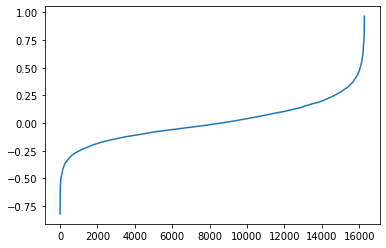

Number of features:  16278
! # ##book ##fukushima ##youtube #0215 #034 #039 #06 #09 #1-1st #1008pla #1008planet #124 #140 #16 #163 #17 #171 #2015 #20150613 #22days #24 #263chat #2a #2fast2furious #2minutemix #360wisenews #365disasters #37592 #38745 #3novices #452 #4playthursdays #5sosfam #615 #629 #7newsadl #8217 #8392 #89x #911 #9973 #999day #9newsmornings #abandoned #abbott #abc #abc7eyewitness #abcnews #abha #ableg #abomb #abstorm #accident #accidentalprophecy #acenewsdesk #achedin #act #actionmoviestaughtus #adani #addtexastonext1dtour #adiossuperbacterias #adjust #adult #aeroplane #aerospace #afc #afghanistan #afp #africa #africanbaze #africansinsf #after #afterhaiyan #afterlife #aftershock #age #aids #aintsheperty #aircraft #airplane #airport #airwaves #alameda #alaska #alaskaseafood #albany #alberta #algeria #allah #alllivesmatter #allthekidneybeansandsorbet4misha #allthenews #alps #alrasyid448iturasya #alt #alwx #amageddon #amazon #ambulance #amicospizzato #amreading #amssummer

... . . .. ... ... ... / /8 /: 0 0.45 0.6 0.75 0.9 00 000 00:11 00:25 00:52 00pm 01 01-06 012 014 01:01 01:02 01:04 01:11 01:20 01:26 01:50 02 02-06 025 03 03-08 03/08 030/6 032 05 05.08 05th 06 060/5 061 066gp 06:32 06:34 06jst 07 07:30 08.05 08/02 08/05 08/06 08/07 08/3 0840728 08780923344 08:00 08:02 09 097 09:13 09:36 0fsloths 0npzp 0sed 1 1-6 1.00 1.13 1.2 1.25 1.3 1.4 1.43 1.5 1.9 1.94 1/13 1/2 1/2007 10 10-6 10/3 100 100.000 1000 1000s 100bn 100mb 100nd 100s 101 1028 103 105 106.1 106:38 107 107.9 10:00 10:15 10:30 10:34 10:38 10:40 10am 10k 10km 10m 10news 10pm 10th 10w 10x 11 11.2 11000 111020 114 1141 1145 115 119000 11:00 11:03 11:15 11:30 11:45 11am 12 12.5 1200 12000 12022 123 1236 124.13 125 129 12:00 12:11 12:32 12hr 12jst 12m 12mm 12news 12th 12u 12v 13 13,000 130 13000 133 138:8 14 140 14000 14028 143 148 149 14th 15 150 1500 15000270364 15000270653 158-0853 158-1017 159 15901 15:04 15:41 15km 15t 15th 16 16.99 160 1600 1620 163 165000 16550 166 1665 1686b 16:11 16:40 

 campus cams can can't can'twon't canaanites canada canada's canadasuicide canadian canal canberra's cancel canceling cancelled cancels cancer cancers candidates candle candy candylit cannibalism cannon cannot canoe cans cant cantar canvas canyon cap capable capacity cape capital capitalism capitalist capitulation capoeira caps capsize capsized capsizes captain caption captives captivity captors capture captured captures capturing car car-induced cara caravans carb carbondale carcinoma card cardboard cards care cared careen career career-best careerism careers careful carefully careless carful cargo carhot caribbean caribean caring carl carlos carmel carmi carmike carnage carnegie carolina carolinaåêablaze caroline carpet carpooling carr carriage carried carry carryi carrying cars cart carted cartel carterville cartoon cartoony-like cartridges caruana cary cas cascada cascade case cases cash casing casino cast castello casting castle casu casual casually casualties casualty casualty-gr

directions directly director directors directory diretube dirt dirumah dis disagreements disappear disappearance disappeared disappearing disappears disappointed disappointing disappoints disarmed disaster disaster-related disasters disciplinary disclaimer disclos disclosed disco disconnected discount discourse discovered discovery discuss discussed discusses discussing discussion disdain disea disease diseases disembarkment disfigured disgrace disgusting disillusioned disinfo dislike dislocation dismantling dismayed dismissed dismisses disney disney's disneyland disorder disorders disowned disowns dispatch dispatchers dispensary dispersed displace displaced displaces display displeased dispute disregard disrespect disrupted disruptive disrupts diss dissertation dissuaded distance distinct distinction distraction distress distributed distribution district disturbances ditched ditto div dive diver divers diverse diversified diverted diverts divestitures divided divine diving division di

 fyi fylde g g20 g3 g7 ga gabon gadgets gaelite gag gagnon gaia gail gain gained gainesville gaining gains gal galactic galactic's galaxy galifianakis galleria gallipoli gallup gambia gambit game game-day gameofkittens gameplay gamer games gamescom gamma gander gang gangstermail gansey gap gaping garage garbage garbage-bot garden gardens gards garfield gargoyle gary garza gas gasoline gasparc gasped gasping gastric gate gateau gates gauteng gauze gave gay gaynor gays gaza gazans gazebo gazette gba gbbo gbonyin gc gd gear gearing gears gecko geek_apocalypse gel geller gem gemini gems gemstone gen gene general generally generation generational generic generous geneva genisys genitals genius genocide gentle gentlemen gently genuine geometric george georgia georgina german germany germs gesserit gesture get gets gettin getting geyser geysers gf gg ghe ghetto ghost ghosts ghostwriter ghostwriting ghoul ghul gi giannis giant giants gibraltar gif gift gifts gig gigant gigawatts giggling gilgi

jarmusch jasmine jasmines jason's java jawans jax jay jaylenejoybeligan jays jazz jazz's jbumzqpk jealous jeans jeb jedi jeep jeepåêsunk jeez jeff jefferson jen jenna's jenner jennifer jerkface jerry jersey jerseys jerusalem jesse jesus jesus's jet jets jetstar jewelry jewels jewish jews jez jfc jhaustin jhmnye jiahahahha jihad jihadi jihadis jim jimin jimmy jinx jitsu jittering jkl job jobbing joboozoso jobs jocelyn joe joel joes joeysterling jogger johannesburg john johnny johns johnson join joined joining joint joints joke joked jokin jolie jon jonas jonathan jones jonesboro jordan jose joseph josephus josh joshua josie jota journal journalism journalist journey journey's journeys journo joy joys jp jr jrowah js jsdf jst juan juanmthompson juanny judas judge judgement judicial judith juice juicy jul julian julie juliet july jump jumped jumper jumper-ca jumpin jumps jun junction june juneau jungle junk junko jupiter's jurors jury jus just just-married justice justified justifying jus

 mortal mortar mortified morty moscow moseby mosh moshav mosque mosquito mosquitoes most moth mothe mother mothernaturenetwork motion motivated motivation motivator motley motogp motor motorcraft motorcycle motorcycles motorcyclist motordom motorists motors moulding mount mountain mountaineering mountainous mountains mounting mounts mourning mourns mouse mousse mouth move moved movement moves movie movies moving movt moyo mp mp.my mp3 mpc mph mpp mr mr.affleck mr.obama mrc mre mrw ms msf mt mthe mtr much mud mudslide mueller muffle mugged mukilteo mulan mulberry mullah mullin multi multi-casualty multi-racial multidimensi multidimensional multiplayer multiple mum mum's mumbai mumbaitimes mumbling munch municipal murder murdered murderer murderer's murderers murderous murders murfreesboro murlo murphy muschamp's muscle muse museum mushroom music musician musicians musicvideo musik musk muslim muslims must must've mustard mustering mutant mute mutilated mutt mutual muzzamil muzzies mv mw

problems probs proc procedures proceeds process prod prodding produc produce produced producer produces product production productive professional professionally profile profit profit-hungry program programme progress progressive progressives prohibits project projected projectiles projects proliferation prolly prolong prom promise promised promises promote promoted promotion prompt prompted prompting prompts proms prone pronouncing proof propaganda propane propelled proper properly property property-casualty prophecy prophet prophets proportions proposal proposed pros prosecute prosecuted prosper prosser protect protected protecting protection protector protein protest protesters protesting protestors protests proto-states protoshoggoth proud prove proven provide provided providence providers province provocation provoke provokes proxies proxy prysmian ps ps1 ps2 ps3 ps4 psa psalm psalms psfda psm psp psqd psychiatric psychic psychological psychologist pt1 pt4 ptsd pub public publicat

 stand-user standard standardised standardized standards standing stands standstill stans star starbs stardate stare stark starks starmade starr starring stars start started starter starting starts startup startups starve starving stat state state's statement statements states statesville station stations statistically stats status stavola stay stayed staying stays stds steady steak steal stealing steals stealth steam steamship stearns steel steep stefano stem stemming step stephen stephenscifi stephenson stepkans stepped steps stereo sterling sterling-scott stern sterotypical steve steven stevie stew stewart stick sticker sticking sticks sticky stil still stillness stir stirring stl stlnd sto stock stockholm stocks stockton stockwell stokes stole stolen stomach stone stones stonewall stony stood stop stopped stopping stops store store's storen stores storey stories storm storm's storm-free stormcoming storming storms stormtrooper story stout stowing straight straighten strain strains 

wording wordk words work workd worked worker workers workforce working workout workplace works workspace world world's world.lets worldnews worldoil worldpay worlds worldwide worn worried worries worry worrying worse worseits worsen worship worst worst-ever worth worthless would would've wouldn wouldn't wouldnt wound wounded wounds wow wow-the wowo wpd wpri wpt wqow wr wraith wrap wrapped wrapup wreak wreck wreckage wrecked wrestler wrightsboro wrinkled wrist wristband write writer writers writing writings written wrked wrong wrong-way wrote wroug wrought wsjthinktank wsls wsoc wsvr wtc wtf wth wud wut ww ww1 ww2 wwa wwe wwi wwii www wxia-tv wy wyou wyrmwood x x'mas x-files x-men x-post x-ray x-rays x1386 x1392 x1402 x1411 x1434 x1441 x2 x36 xavier xb1 xbox xd xekstrin xela xii xkdrx xl xl61 xo xoxo xp xv xvii xxhjesc xxx y y'all ya yahoo yakub yall yamaguchi yamashiro yankees yard yay yazidis yday ye yea yeaahh yeah yeahs year year-old years yeat yeda yee-haw yehuda yell yelled yellin

In [50]:
cv = CountVectorizer(tokenizer=tt.tokenize)
cv.fit(train['text'].apply(lambda x: re.sub('(http|@)[!-~]*(\s|$)', '',x)))

# Vectorize keywords and tweets
# First the training set
train_keywords = pd.DataFrame(pd.get_dummies(train.keyword,prefix='KW'))
train_tweets = pd.DataFrame(cv.transform(train['text']).toarray(),columns=cv.get_feature_names())
X_train = pd.concat([train_tweets],axis=1)
y_train = train.target

test_keywords = pd.DataFrame(pd.get_dummies(test.keyword,prefix='KW'))
test_tweets = pd.DataFrame(cv.transform(test['text']).toarray(),columns=cv.get_feature_names())
X_test = pd.concat([test_tweets],axis=1)
y_test = test.target

model = RidgeClassifier()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred))

coef = [(X_train.columns[i],model.coef_[0,i]) for i in range(len(X_train.columns))]
coef = sorted(coef, key = lambda x: x[1], reverse=True)

print('Top 20 terms favoring Disaster:', ' '.join([x[0] for x in coef[:100]]),'\n')
print('Top 20 terms favoring Not Disaster:', ' '.join([x[0] for x in coef[-100:]]))

plt.plot(sorted(model.coef_[0,:]))
plt.show()
print("Number of features: ", model.coef_.size)

for col in X_train.columns:
    print(col,end=' ')

## Get rid of hashtags

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


              precision    recall  f1-score   support

           0       0.96      0.99      0.98      4342
           1       0.99      0.95      0.97      3271

    accuracy                           0.97      7613
   macro avg       0.97      0.97      0.97      7613
weighted avg       0.97      0.97      0.97      7613

Top 20 Disaster features: #hailstorm distance riots balls sj insomnia wildfire suing declares jrowah daviesmutia derailment hailstorm grateful sevenfigz moly holly sincere telnet thruuu stab earthquake ij externally subsd acrylic tianta narrowly connector threatens ryans aware outs drought taxis onto quarter fires hyider_ghost michigan riveeer sunburned ipod bf nails shore opens mall nuff massacre overlooking rises mwednesday faceåê prob abs moir websites #hiroshima fandom pornhub harms cos sfa countries dumb lich chim #bowe typhoon sunset floods horrible hoo aubrey thirsty packages peacefully obligations jets bartender gearing apt curb snap liberal tanzania spin r

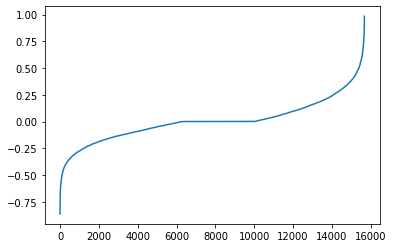

Number of features:  15673


! # #1008pla #1008planet #ariz #assassins #bowe #collegeradi #dagens #easternoregon #emsne #explodingkittens #freaky #frofrofro #greetingcards #growingupincolorado #hailstorm #hannaph #helsinki #hiroshima #ices #interestraterise #japì_n #katterpì #marijuana #mì¼sica #newyork #nå¼florence #pakistan #sirens #sto #tcotåê #urbanfashion #vra50 $ ' ( ) + . / 10 2.4 30 3åê 4000 4608ìñ 5 53 600 70 91å : :/ :: :\ :d :p ; ;p = =p > ? @ [ \ ] ]: ^ _ __ _one ` a aa aaa aaalll aaand aageneva aakarlsruhe aan aannnd aar aashiqui ab aba abandon abandoned abandoning abbandoned abbott abbruchsimulator abbswinston abc abcnews abcof abe abegovernment aberdeen aberystwythright abia ability abject ablaze ablazethanks able aboard abomination abortion abortions about abouts above aboybeen abs absence absolute absolutely abstract absurd absurdly abuse abused abusedher abuses abusing ac academia acc accept accepte accepts access accident accidentally accidentita accidently accidents accidentsthe accidentterribl

 nobody noches nockthie noel noemotion nofor nofuel noi noise noises nometro nominations nomiya non nonchemicals nondrop none nonecontemplating nonexternal nonot nonspeaking nonthreatening noob noodles noonanin nooo nope nor nora noranda norfolk normal normally norman norse nort north northampton northbound northeast northern northgate northgrayed northland northumberland northumbria northwest northwestern northwestthat nose noses noshow nosso nostalgia nostick nostrils not notbut note noted notes notexplained nothe nother nothing nothingness notice noticed notices notifications notificationsgo notificationsu notified noting notion notley notleytactful notoriety notorious notre notready nottingham nout nov nova novel novels november now nowbc nowbut nowcheck noweveryone nowhere nowit nowlife nowlove nowplaying nowright nowsenator nowt nowthata nowww nowyeah nowyoubetter noxdv nrc nrc_middleeast ns nsa nsf nside nsw ntsb nu nuclear nuclearbrigade nuclearindopact nude nudes nueva nuff nu

 reactors reacts read readerperson reading reads ready reafs reagan reaganlandslide real realinsight realise realised realism realistic realities reality realization realize realized realizedjust really reallydo reallysadly realm realtime realtimeit reap rear rearvia reason reasons reassigned reator rebahegoing rebecca rebelled reblogged reboot reboundd rebuilding rec recal recall recalled recalls recap recapnigerian recappic receive receives receiving recent recently recentlysee recip recipe recipes reckless reckon recognised recognize recoil recommend recommendations recommended reconnect record recordand recorded recordingby recordstates recount recover recovered recovery recreates recruiting recruitment recycling red redagain redbull redcliffe reddit redditnew redeem redeemer redeemeth redemptionplatt redesigned redesigning rediscover rediscovered redlands rednearby redo redrunners redrunning reduce reduced reduces redwing reebok reed reef reeves refer reference referencereference 

soi soil solano solar sold soldi soldier soldiers soldiersdeaths sole solicitor solid solitude solo soloquiero solution solve solved solving somalia some somebody somehow someone someoneback someonedoor someonegonna someones somethin something somethingnot sometimes sometimesi sometimeslike somewhere somme son sona soner song songa songfor songs songyears sonhim soni sonia sons sony soo soon soonrip sooo sophie sophistication sore sorely sorrow sorrower sorrowful sorrows sorry sorrybuilt sort sothwest souda soudelor soudelorpredicted soudeloru sought soul soulja souls soultech sound sounders sounding sounds soundsvia soundtrack soup sour source sources sousse south southampton southbound southdown southeast southern southsaudi southwest soviet sow soz sp space spaceship spacex spain spam spammers span spaniel spaniels spanish spanishsweet sparked sparking sparks sparkz spartans sparxxx speak speaker speaking spears speccy special specialguest specialist specialists specialiststonight s

 thatthe thatthere thattimes thatto thattrue thatwgoing thatwhat thatwhen thatwhere thatwhy thatyour thda the the_af theater theatre theatresbut thee theeblessed theft their theirsactual them thembut themco theme themed themeverything themfatalitieswhy themhe themhope themi themif themkeep themmy themobliterate themrt themselves themsomeday then thenexplains theological theory therapies therapy there therea thereamerican therean thereare therebeen therebooze therebride theredevastated therefive therefreeman thereha therehalf therehot therein thereittotally thereliterally therelots theremore therenew therenothing thereof therepalms therepeople therepolitor therereally theres therestill therethat therethe therethis theretrouble these thesensualeye thevia they theyall theybe theybuilt theycharged theycollectibles theycome theydrive theyelectrocute theyever theyfo theygoing theygonna theygrab theygraduated theyheaded theyin theylucky theynot theyon theyonly theypretty theyprobably theyre t

values vampires vampiro vampirocut van vancouveråêisland vandalized vanderbilt vanessa vanessagame vanilla vanished vanishing vantage vanthology vape variety various vashon vassalboro vast vault vchemical ve vector veg vegas vegasi vegasx vegetable vegetableimages vegetables vegetarian veggies vehicle vehiclei vehicleplease vehicles vehiclestake veil veins vela veld veneto venezuela venice venoms vent ventilated venture verde verdict verge vergil verhoek vermilion vermont versethe version versions versus very vessel vessels vest vestment vet veteran veteranaccess veterans veteransoifvets vets vi via viab vibemusic vibez vibrate vibrates vibrator vice vicinity vickers victim victims victorian victoriasecret victorinox victorious victory vida vidcomin video videos videothe videothreatens videovia vidprod vietnam vietnamese view views vigilentcivil vigils vikings villa village villagers villages ville vince vincent vine vines vinnie vintage vinyl violated violation violations violators vi

In [116]:
cv = CountVectorizer(tokenizer=tt.tokenize)
cv.fit(train['text'].apply(lambda x: re.sub('(#|[!-9]|http|@)[!-~]*(\s|$)', '',x)))

# Vectorize keywords and tweets
# First the training set
train_keywords = pd.DataFrame(pd.get_dummies(train.keyword,prefix='KW'))
train_tweets = pd.DataFrame(cv.transform(train['text']).toarray(),columns=cv.get_feature_names())
X_train = pd.concat([train_tweets],axis=1)
y_train = train.target

test_keywords = pd.DataFrame(pd.get_dummies(test.keyword,prefix='KW'))
test_tweets = pd.DataFrame(cv.transform(test['text']).toarray(),columns=cv.get_feature_names())
X_test = pd.concat([test_tweets],axis=1)
y_test = test.target

model = RidgeClassifier()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred))

coef = [(X_train.columns[i],model.coef_[0,i]) for i in range(len(X_train.columns))]
coef = sorted(coef, key = lambda x: x[1], reverse=True)

print('Top 20 Disaster features:', ' '.join([x[0] for x in coef[:100]]),'\n')
print('Top 20 Not Disaster features:', ' '.join([x[0] for x in coef[-100:]]))

plt.plot(sorted(model.coef_[0,:]))
plt.show()
print("Number of features: ", model.coef_.size)

for col in X_train.columns:
    print(col,end=' ')

In [115]:
token = '#collegeradi'
regexp = '(:|#|[!-9]|http|@)[!-~]*(\s|$)'
raw_matches = [x for x in train['text'] if token in re.sub(regexp, '',x).lower()]
tokenized_matches = [re.sub(regexp,'',x).lower() for x in raw_matches]
print(raw_matches)
print(tokenized_matches)

["Another hour! It's August 05 2015 at 08:02PM Here's Red Rover Zombie Apocalypse 2014! http://t.co/cf9e6TU3g7 #internetradio #collegeradi\x89Û_"]
['another houritaugust at herered rover zombie apocalypse #collegeradi\x89û_']


In [76]:
string = 'This machine really captured my attention. #helicopter #firefighting #wildfire #oregon #easternoregon\x89Û_ https://t.co/V6qxnFHRxF'
re.sub(regexp, '',string)

'This machine really captured my attention#easternoregon\x89Û_ '

# Unsupervised methods

Now we can ask the question, why does it work so well? Here we can look to the patterns in the data using unsupervised methods. 

Can we turn the problem around and predict the keyword from the tweet text? If we did a topic analysis, would the topics map to keywords?

In [7]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

nmf = NMF(n_components=200, random_state=1,
          alpha=.1, l1_ratio=.5)

nmf.fit(X_train,y_train)

n_components = 10
n_top_words = 20


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()
    
print_top_words(nmf,X_train.columns,n_top_words)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Topic #0: the that by was are with world has about at after still not last first more it's out we years
Topic #1: ? # why follow so la airlines missing aircraft debris reunion _ found no u mh370 crush malaysia KW_crush this
Topic #2: . with s it will not was & no u be p we they have it's o he KW_detonate m
Topic #3: : rt 2015-08- û_ california from as at 05 [ ] pm news s utc train police over ( 3
Topic #4: a like was by at up get this but video with from what just after watch that under sandstorm KW_sandstorm
Topic #5: ' from as are families wreckage by KW_wreckage confirmed who conclusively | were those mh370 malaysia ) it's video rescuers
Topic #6: ! be & all out what please we news from wind ass check day KW_loud%20bang bang just loud hey unconfirmed
Topic #7: to be with going have or get make want go how as do it out over not we back so
Topic #8: in killed suicide / crash people bomber who police up fire KW_hostages accident land two hostages released as are bomb
Topic #9: i it was

In [8]:
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
lda.fit(X_train,y_train)
print_top_words(lda, X_train.columns, n_top_words)

Topic #0: ' : more california by storm ; - here wildfire over than oil latest the northern KW_wildfire outbreak KW_razed damage
Topic #1: KW_windstorm windstorm tornado KW_mudslide mudslide KW_tornado fatalities KW_fatalities rules siren demolished KW_demolished crushed KW_crushed mph upheaval KW_upheaval super KW_siren nice
Topic #2: : ? ... in from of # mh370 on legionnaires - wreckage confirmed malaysia KW_wreckage is the found police missing
Topic #3: homes > collapse natural $ released KW_nuclear%20reactor KW_natural%20disaster meltdown KW_meltdown calgary reactor bridge KW_detonation detonation yourself bags KW_collapse KW_body%20bags gems
Topic #4:  : - û_ in for ... of disaster emergency to crash û ûªs full #news obama by a +
Topic #5: : - / ( ) the ... of at a . video in via s on pm fire by from
Topic #6: * screaming reddit lightning ruin KW_ruin KW_screaming screamed KW_screamed KW_quarantine quarantine KW_screams sirens KW_lightning spill screams offensive projected KW_sire

In [9]:
for col in X_train.columns:
    print(col,end=' ')

KW_ KW_ablaze KW_accident KW_aftershock KW_airplane%20accident KW_ambulance KW_annihilated KW_annihilation KW_apocalypse KW_armageddon KW_army KW_arson KW_arsonist KW_attack KW_attacked KW_avalanche KW_battle KW_bioterror KW_bioterrorism KW_blaze KW_blazing KW_bleeding KW_blew%20up KW_blight KW_blizzard KW_blood KW_bloody KW_blown%20up KW_body%20bag KW_body%20bagging KW_body%20bags KW_bomb KW_bombed KW_bombing KW_bridge%20collapse KW_buildings%20burning KW_buildings%20on%20fire KW_burned KW_burning KW_burning%20buildings KW_bush%20fires KW_casualties KW_casualty KW_catastrophe KW_catastrophic KW_chemical%20emergency KW_cliff%20fall KW_collapse KW_collapsed KW_collide KW_collided KW_collision KW_crash KW_crashed KW_crush KW_crushed KW_curfew KW_cyclone KW_damage KW_danger KW_dead KW_death KW_deaths KW_debris KW_deluge KW_deluged KW_demolish KW_demolished KW_demolition KW_derail KW_derailed KW_derailment KW_desolate KW_desolation KW_destroy KW_destroyed KW_destruction KW_detonate KW_deto

#northerncalifornia #nosurrender #notgoingoutinthat #notrocketscience #novalismi #now #nowplay #nowplaying #np #nra #nri #ns #nsfw #nuclear #nuclearweapons #nude #nuke #nursing #nv #nwo #nws #nwt #ny #ny35 #nyc #nyg #nytimes #nz #nå¼36 #obama #obliteration #occasion2b #ocnj #offers2go #offshore #oil #oilandgas #ojoubot #ok #oklahoma #oktxduo #okwx #olympia #omg #oneborn #oneheartonemindonecss #onlinecommunities #onthisday #oocvg #oomf #ootd #oped #opp #opseaworld #or #orapinforma #orchardalley #orcot #oregon #orpol #orshow #osi2016 #otd #otleyhour #otrametlife #otratmetlife #overwatch #ovofest #p2 #painting #pakistan #palermo #palestine #palestinian #palestinians #palmoil #pandemonium #pantherattack #papicongress #papiichampoo #paraguay #paramedic #paramedics #paranormal #parents #parkchat #pathogen #patriots #patriotsnation #paulhollywood #pbban #pbs #pdx911 #pearlharbor #people #peritoengrafoscopia #perrychat #personalinjury #perspective #pets #pft #philippines #phoenix #phone #photo

... .  . . . .. ... ... ... / /8 /: 0 0.45 0.6 0.75 0.9 00 000 00:11 00:25 00:52 00pm 01 01-06 012 014 01:01 01:02 01:04 01:11 01:20 01:26 01:50 02 02-06 025 03 03-08 03/08 030/6 032 05 05.08 05th 06 060/5 061 066gp 06:32 06:34 06jst 07 07:30 08 08.05 08/02 08/05 08/06 08/07 08/3 0840728 08780923344 08:00 08:02 09 097 09:13 09:36 0fsloths 0npzp 0sed 1 1-6 1.00 1.13 1.2 1.25 1.3 1.4 1.43 1.5 1.9 1.94 1/13 1/2 1/2007 10 10-6 10/3 100 100.000 1000 1000s 100bn 100mb 100nd 100s 101 1028 103 105 106.1 106:38 107 107.9 109 10:00 10:15 10:30 10:34 10:38 10:40 10am 10k 10km 10m 10news 10pm 10th 10w 10x 11 11.2 11000 111020 114 1141 1145 115 119000 11:00 11:03 11:15 11:30 11:45 11am 12 12.5 1200 12000 12022 123 1236 124.13 125 129 12:00 12:11 12:32 12hr 12jst 12m 12mm 12news 12th 12u 12v 13 13,000 130 13000 133 138:8 14 140 14000 14028 143 148 149 14th 15 150 1500 15000270364 15000270653 158-0853 158-1017 159 15901 15:04 15:41 15km 15t 15th 16 16.99 160 1600 1620 163 165000 16550 166 1665 1686b 

 http://t.co/b4k0r4gga8 http://t.co/b5okgpspbh http://t.co/b5s5epj7um http://t.co/b6nphxorzg http://t.co/b6wwq2nyqi http://t.co/b77t2qxdcs http://t.co/b8iwrdxcm0 http://t.co/b8n6e4ryvz http://t.co/b9jaxx0vcf http://t.co/b9kuylcxg4 http://t.co/b9zx2xz6aw http://t.co/ba2rrxugsg http://t.co/ba4pusvjln http://t.co/babmf0w2yw http://t.co/bae0ap4g9y http://t.co/bagef9lfgt http://t.co/baqocmcjqc http://t.co/bb7ttdvjwe http://t.co/bbdpnj8xsx http://t.co/bbjls1fsad http://t.co/bbm9sr1wow http://t.co/bbqnk76qus http://t.co/bccca4vy9r http://t.co/bcdp4gkoka http://t.co/bcjylerryx http://t.co/bcldqmmehg http://t.co/bclqpwfdod http://t.co/bcpmvylsih http://t.co/bcsxyec4ji http://t.co/bd52fxdvhq http://t.co/bdn2fdpdaz http://t.co/bdotq8dsln http://t.co/bdsgf1cfax http://t.co/behfhsppud http://t.co/bekrpjnyhs http://t.co/beua507iug http://t.co/bfes5twbzt http://t.co/bfthahlcr0 http://t.co/bftiapf35f http://t.co/bgaj2oax1p http://t.co/bgerljamte http://t.co/bgm4csrbvd http://t.co/bgrab7lk8d http://t.c

 http://t.co/jjxcnwbp15 http://t.co/jk7npdpwro http://t.co/jkc0diqvxc http://t.co/jkd7cti2iw http://t.co/jkpjpch9i6 http://t.co/jkym9edofc http://t.co/jlczidz7vu http://t.co/jliemrsnnj http://t.co/jlmicj6je5 http://t.co/jlput7va3s http://t.co/jlu2j5qs8u http://t.co/jlwgshyy3n http://t.co/jlwhaowfqa http://t.co/jlzk2hdetg http://t.co/jmawrlt7hb http://t.co/jmbvpanxr3 http://t.co/jmkywhv7mp http://t.co/jmu5uyamdu http://t.co/jmzcaqydfa http://t.co/jn8s0drwbp http://t.co/jnhnx3oisn http://t.co/jnn0krnxvy http://t.co/jnromse1z2 http://t.co/job4ggtpal http://t.co/jobvbvkfnz http://t.co/jods9a32pi http://t.co/jp2qlrunjj http://t.co/jp3oy0ouxq http://t.co/jp9xyla3c5 http://t.co/jpa6sajfe3 http://t.co/jphgpl1c5x http://t.co/jpu3es746i http://t.co/jpu9gips9f http://t.co/jq2eh5kglt http://t.co/jq9nj6gko3 http://t.co/jqfcy9guqv http://t.co/jqso4fyzp4 http://t.co/jqxm4gcqz3 http://t.co/jrdwyy0ax4 http://t.co/jrgj17oamt http://t.co/jrxgolnpqw http://t.co/jrztpt8ijq http://t.co/js9ehp88wq http://t.c

http://t.co/phh1vmlfoo http://t.co/phixznv1yn http://t.co/phnez60cwe http://t.co/pijg5w2l2u http://t.co/pioy1o54f4 http://t.co/pis0aivrbr http://t.co/piveupirky http://t.co/pjigxpvpl0 http://t.co/pjlda9hd5v http://t.co/pk8dgvripw http://t.co/pkfv8lksld http://t.co/pkkcdwjyg0 http://t.co/pkuamxw6pm http://t.co/pl2vzlrkvk http://t.co/plmiwofpom http://t.co/plo2qkrwhu http://t.co/plqf1biks4 http://t.co/pm2tnnfdww http://t.co/pmbuzfgin3 http://t.co/pmcp8czpnd http://t.co/pme0hojvya http://t.co/pmggavtokp http://t.co/pmhmmkspaq http://t.co/pmlohzurwr http://t.co/pms4pmur0q http://t.co/pmtqhivsxx http://t.co/pmxezuo4ay http://t.co/pnaqxprweg http://t.co/pnhpljho8e http://t.co/pnlucerp0x http://t.co/pnnunrnqja http://t.co/pnssia5e46 http://t.co/po19h8ycnd http://t.co/pol92mn8yz http://t.co/pp05etlk7t http://t.co/ppekbqdcnc http://t.co/ppji1tcnml http://t.co/pq0d7mh3qr http://t.co/pq3ipugkuy http://t.co/pqhuthss3i http://t.co/pqrjvgvgxg http://t.co/pramklrmhz http://t.co/praro2owia http://t.co

http://t.co/targ56igbz http://t.co/tatzfk63ch http://t.co/taxuxp9qa2 http://t.co/tb52o146tx http://t.co/tb8gzembxu http://t.co/tbbobvcotj http://t.co/tbm9fqb8cw http://t.co/tbpqlyfyot http://t.co/tbqsqtmqv4 http://t.co/tbstk5vqu0 http://t.co/tbx8cakdrw http://t.co/tcjfckxdzl http://t.co/tcs2cd5y6y http://t.co/tcsolvwhxq http://t.co/tcxxhdjas6 http://t.co/tdaktglu5p http://t.co/tdcch01n7q http://t.co/tdeqwm8zxn http://t.co/tderbtgz2k http://t.co/tdeukjzzii http://t.co/tdhn9zy0er http://t.co/tdwprvb04y http://t.co/te2yerugsi http://t.co/te5tdlyimn http://t.co/tegajmr8il http://t.co/teq7sri57p http://t.co/tezltqeyw2 http://t.co/tf2bkq0olx http://t.co/tfan6qq2ys http://t.co/tfcdronra6 http://t.co/tfeanwhh2h http://t.co/tft1bb4xaz http://t.co/tg5fqc8zey http://t.co/tgcr5vofj3 http://t.co/tgdonttkty http://t.co/tglk2uus2z http://t.co/tgtcru8jio http://t.co/tgxutuoyhl http://t.co/th2wlilbmo http://t.co/th9ywbbeet http://t.co/thhjjw51pe http://t.co/thmblaatzp http://t.co/thnexicgqe http://t.co

 http://t.co/wx11d69gez http://t.co/wxbrarc7p3 http://t.co/wxces39zte http://t.co/wxhmp5ppjq http://t.co/wyokt0ftrw http://t.co/wz55nbyao3 http://t.co/wzedxefblg http://t.co/wztz4hgmvq http://t.co/x0giy85bs8 http://t.co/x0qlgwoymt http://t.co/x1onv3d5ux http://t.co/x1x6d5enef http://t.co/x1xj0xvtj7 http://t.co/x2qsjod40u http://t.co/x39jwsyrqr http://t.co/x3g2ox6k8r http://t.co/x3rcchkago http://t.co/x3vqxdouvt http://t.co/x4ecggvnsn http://t.co/x5jgkjv6ma http://t.co/x5rc5nuamh http://t.co/x5xumtoeke http://t.co/x5yeuylt1x http://t.co/x6asgrjswc http://t.co/x6el3ysycn http://t.co/x713omh6ai http://t.co/x8i0mhyrmn http://t.co/x8moyevjsj http://t.co/x8w7tf6fhg http://t.co/x8zqbwnfo1 http://t.co/x9cuihib5n http://t.co/x9mdhocpda http://t.co/x9ofv1kmv7 http://t.co/xaermbmvlv http://t.co/xbmm7ite9q http://t.co/xbnlsbzzgi http://t.co/xbznu0qkvs http://t.co/xc96rwuszb http://t.co/xcgzc45gys http://t.co/xcolwugfjg http://t.co/xcq48ourvl http://t.co/xdt4vhfn7b http://t.co/xdxdprcpns http://t.c

incidental incidents incinerator incite incitement inciting inciweb include included includes including income incompetent increase increased increasing increasingly incredible incredibly incredulous incremental ind indah indecency indecisiveness indeed independence independent indepth index indexing indi india india-backed indiahttp indian indiana indianapolis indianperpetrated indians indictment indie indiegogo indifference indiscriminate indistinguishable individl individual individuals indo-japan indonesia indonesian indoors indot industrial industry indy indyfest inec inequality inevitable inevitably infact infamous infantry infantryman infected infections infectious inferior inferno infested infield infiltrated infiltration infinite infinity inflicted influenced influencers influential info infographic infomercial informant information infowars infrastructure inhofe initial initiative inj inject injured injures injuries injury injustice ink inmate inmates inner inning innings inn

mediterranean medium meds medusa meek meelllttting meerkat meet meeting meets meg mega megadeth megadeth-symphony megalpolis megan melanie mello melt meltdown melted melts member members membuahkan meme meme-baiting memes memorable memorial memories memory memphis men men's menahem mencius mens mental mentality mentally mention mentioned mentions meowing mercenary mercury mercy mere merged merle mesh mesick mesmerizing mess message messages messed messenger messengers messi messiah messy met metal metallica metaphorically metastatic meteors meter meters method methods metlife metre metrics metro metrobus metroid metropolis metropolitan metrotown mets mexican mexico mezcal mf mfi mfs mgm mgr mgs mh mh17 mh370 mhmmm mhtw mi mia miami mic michael michel michele michigan micom microbes microchip microlight microphone microsoft microsoft's microsofts microwave mics mid mid-day mid-morning mid-south middle mideast midfield midges midget midnight mido midst midsummer midtown midweek midwest m

phenomenal phew phil philadelphia philip philippi philippine philippines phillip phillips philly phoenix phone phones photo photo-op photogenic photographed photographer photographs photography photos photoset photoshop physical physically physicians piano pic pic.twitter.com/pnpizody pick picked pickens pickerel picking pickle pickles pickpocket pickup pics picture pictured pictures piece pieces pierc pierce piercing piercings piga pigeon pikachu pikin pile pileq piles pileup pilgrims piling pill pilloried pillow pillows pills pilot pilots pin pine piner pineview pink pinpoint pioneer pipe pipeline pipeliners piping pir piracy pirate pirates pisces pisco pisgah piss pissed pit pitch pitched pitcher pitcher's pitchers pits pittsburgh pity pivot pixar pizza pizzas pkk pkwy pl place placed places placing plague plaguing plains plan plane planes planet planing plank planned planners planning plans plant plant-covered plantations planted plants plastic plastics plate platform platinum plat

rest restart restaurant restaurants resting restive restlessness restore restoring restricted restrospect result resulted resulting results resumed retail retainers retard retirees retirement retooled retract retreat retro retroactive return returned returning returns retweet retweeted reunion reunite reusing reuters rev revealed revealing reveals reveillertm revel revelation revenge revenues revere reversal reverse review reviewers reviewing reviews revise reviving revolt revolution reward reworked rey rezaphotography rgj rhett rhiannon rhinestone rhode rhymes ri ribbon rice rich richard richardson richelieu-saint-laurent riches richmond ricin rick rickets rico ricotta rid ridah riddler ride rider riders ridge ridiculous ridiculously riding rifle rifles rig rigga right righteous rightly rights rights.generally rightways rigour rihanna rijn rin rindou ring rio riooos riot rioters rioting riots rip ripped ripping ripple ripples ripriprip rips ris rise riser rises rising risk risks risky

thalapathi than thank thankful thankfully thanking thankkk thanks that that'd that's thats thda the the_af theater theatre theatres thee theft their theirs them theme themed themhe themselves then theological theory theramin therapies therapy there there's therefore therein thereof theres these thesensualeye they they'd they'll they're they've theyre thh thi thick thief thigh thighs thin thing things think thinking thinks thinner third third-quarter thirst thirsty thirty-five this thisisfaz thnk tho thomas thorgan thorin's thoroughly those thou though thought thoughts thousand thousands thr thranduil thrarchives thread threat threaten threatening threatens threats three three-alarm threesome threw thriller thriving throat thrones through throughout throw throwback throwin throwing throwingknifes thrown thru thrusts thruuu tht thu thuggin thugging thunder thundering thundersnow thunderstorm thunderstorms thurlow thurs thursd thursday thursdays thus thx thy thyroid tianta tic ticket tick

Looking at the word list, there's lots of cleanup that's possible. I think that we can get rid of the following:

- http addresses
- t.co
- tweets at handles (with @ prefixes)
- starts with numbers
- a handful of UTF characters at the end?

I expect that this will considerably speed up fitting and predicting without a large impact on accuracy.

# Named Entity Recognition (NER)

In [10]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jeffreykoskulics/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/jeffreykoskulics/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/jeffreykoskulics/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [11]:
tagged = nltk.pos_tag(tt.tokenize(train['text'][18]))
entities = nltk.chunk.ne_chunk(tagged)
print(entities)

(S My/PRP$ car/NN is/VBZ so/RB fast/JJ)


In [12]:
import spacy

In [13]:
nlp = spacy.load('en')

In [14]:
[nlp(tweet).ents for tweet in train['text'][:20]]

[(May,),
 (La Ronge Sask, Canada),
 (),
 (13,000, California),
 (Ruby, Alaska),
 (#, California Hwy, 20, Lake County, #CAfire #),
 (Manitou, Colorado Springs),
 (),
 (),
 (),
 (Three,),
 (Haha South Tampa, GONNA DO),
 (#raining, #, Florida, TampaBay, Tampa, 18 or 19 days),
 (Myanmar,),
 (80,),
 (),
 (),
 (Summer,),
 (),
 ()]

In [15]:
[nlp(tweet).ents for tweet in train['text'][20:30]]

[(), (London,), (), (a wonderful day,), (), (), (NYC, last week), (), (), ()]